# Structure
* [Dataset](#dataset)
* [Linear Regression with scikit-learn](#linear_reg)
* [Linear Regression with PyTorch](#linear_reg_pytorch)

In [2273]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

## <a id='dataset'> Dataset </a>

In [2274]:
dataset = pd.read_csv('ice_cream.csv')

In [2275]:
dataset.columns = [column_name.lower() for column_name in dataset.columns]

In [2276]:
X = minmax_scale(X=dataset.drop(columns=["revenue"]))
y = dataset["revenue"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2277]:
def get_corr_coef(data: pd.DataFrame, feature_1: str, feature_2: str) -> float:
    corr_coef = data[[feature_1, feature_2]].corr(method='kendall')
    corr_coef = corr_coef[feature_1][feature_2]

    return corr_coef

def show_correlation(data: pd.DataFrame, feature_1: str, feature_2: str):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[feature_1], data[feature_2], color='blue', marker='o')
    plt.title(f"{feature_1} vs {feature_2}")
    plt.ylabel(feature_2)
    plt.xlabel(feature_1)
    plt.grid(True)
    plt.show()

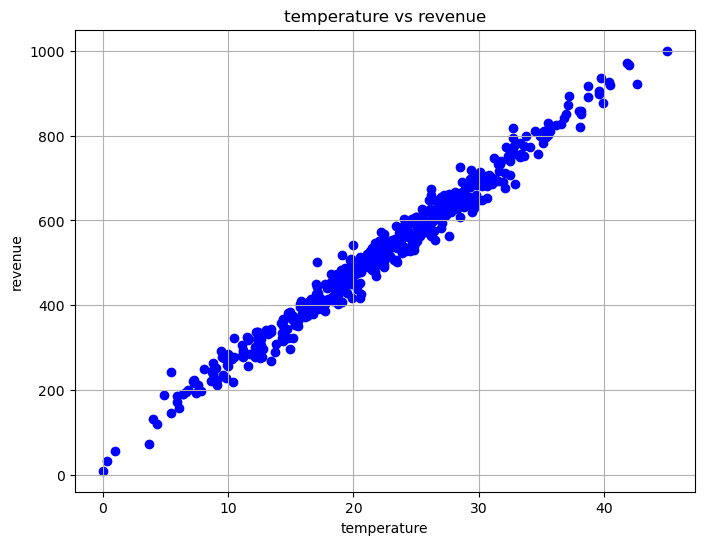

Correlation coefficient for temperature and revenue: 0.9122147585944843


In [2278]:
show_correlation(data=dataset, feature_1="temperature", feature_2="revenue")
corr_coef = get_corr_coef(data=dataset, feature_1="temperature", feature_2="revenue")
print(f"Correlation coefficient for temperature and revenue: {corr_coef}")

#### Based on correlation coefficient and scatter plot we can notice strong correlation between `temperature` and `revenue`
#### We also can see that there are no "strong" outliers that is data is dense

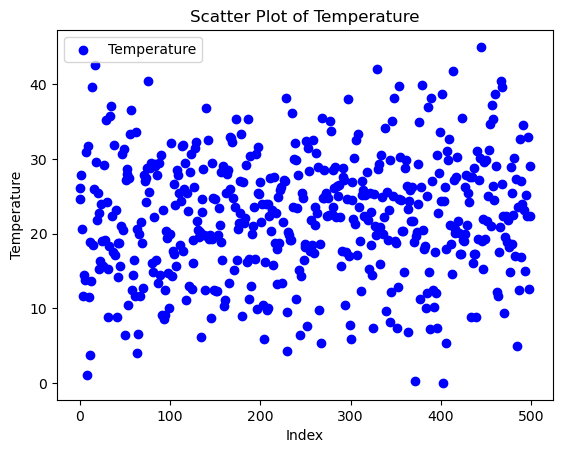

In [2279]:
plt.scatter(dataset.index, dataset['temperature'], color='blue', label='Temperature')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Scatter Plot of Temperature')
plt.legend()
plt.show()

## <a id='linear_reg'>Linear Regression with scikit-learn</a>

### Ordinary least squares Linear Regression.

In [2280]:
# Train model
reg = LinearRegression().fit(X_train, y_train)

In [2281]:
reg_coef = reg.coef_[0]
reg_intercept = reg.intercept_

print(f"Linear Regression coefficient is: {reg_coef}\nLinear Regression intercept is: {reg_intercept}")

Linear Regression coefficient is: 963.9751982399548
Linear Regression intercept is: 45.06352623099809


In [2282]:
def graph(formula, x_range: np.ndarray, X: np.ndarray, y: pd.Series, intercept: float, coef: float):  
    x = np.array(x_range)  
    y_formula = formula(x, intercept=intercept, coef=coef)  
    plt.plot(x, y_formula)  
    plt.scatter(X, y, color='red', label='Data')
    
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def my_formula(x: np.ndarray, intercept: float, coef: float):
    return coef * x + intercept

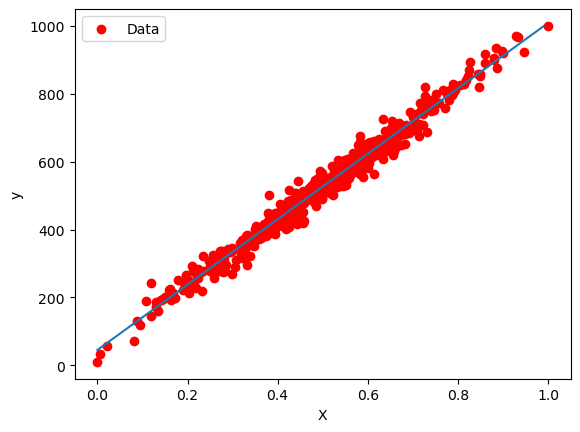

In [2283]:
x_range = np.arange(X.min(), X.max(), 0.01)
graph(my_formula, x_range,  X, y, intercept=reg_intercept, coef=reg_coef)

#### There is really strong correlation so it's not suprising results of the model.

### Linear model fitted by minimizing a regularized empirical loss with SGD.

In [2284]:
criterion = 'squared_error'
penalty = None
random_state = 9
early_stopping = True

learning_rates = ["constant", "optimal", "invscaling", "adaptive"]
n_iters_no_change = [2, 5, 10]
eta0s = [0.01, 0.09, 0.2, 0.7, 0.9]

In [2285]:
best_params = {}
ites = 0
for learning_rate in learning_rates:
    for n_iter_no_change in n_iters_no_change:
        for eta0 in eta0s:
            ites += 1
            regressor = SGDRegressor(
                loss=criterion,
                penalty=penalty,
                random_state=random_state,
                early_stopping=early_stopping,
                learning_rate=learning_rate,
                n_iter_no_change=n_iter_no_change,
                eta0=eta0
            )

            regressor.fit(X_train, y_train)

            score = regressor.score(X_test, y_test)

            if not best_params:
                best_params = {
                    "bias": regressor.intercept_,
                    "weight": regressor.coef_,
                    "score": score,
                    "learning_rate": learning_rate,
                    "n_iter_no_change": n_iter_no_change,
                    "eta0": eta0
                }
            else:
                prev_score = best_params["score"]
                if score > prev_score:
                    best_params = {
                    "bias": regressor.intercept_,
                    "weight": regressor.coef_,
                    "score": score,
                    "learning_rate": learning_rate,
                    "n_iter_no_change": n_iter_no_change,
                    "eta0": eta0
                }

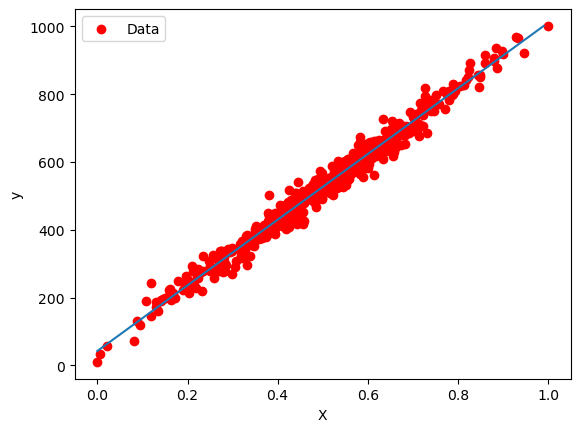

{'bias': array([42.20098102]),
 'weight': array([968.95685572]),
 'score': 0.9799430004729222,
 'learning_rate': 'adaptive',
 'n_iter_no_change': 2,
 'eta0': 0.2}

In [2286]:
graph(my_formula, x_range,  X, y, best_params["bias"][0], best_params["weight"][0])
best_params

## <a id='linear_reg_pytorch'>Linear Regression with PyTorch</a>

In [2287]:
def set_seed(seed):
    """
    The function that sets a random seed to ensure the reproducibility of any randomized processes
    """

    np.random.seed(seed)
    torch.manual_seed(seed)


# Model
class LinearRegression_torch(nn.Module):
    """
    Linear Regression model (single neuron Neural Network)
    """

    def __init__(self, in_dim, out_dim):
        super(LinearRegression_torch, self).__init__()

        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        output = self.linear(x)
        return output

In [2288]:
x_train_torch = torch.from_numpy(X_train.astype(np.float32)).reshape(350)
y_train_torch = torch.from_numpy(y_train.astype(np.float32))
x_test_torch = torch.from_numpy(X_test.astype(np.float32)).reshape(150)
y_test_torch = torch.from_numpy(y_test.astype(np.float32))

train = TensorDataset(x_train_torch, y_train_torch)
test = TensorDataset(x_test_torch, y_test_torch)
train_loader = DataLoader(dataset = train, batch_size = 100, shuffle = True)
test_loader = DataLoader(dataset = test, batch_size = 100, shuffle = True)



In [2289]:
# Setup of random seed (DO NOT CHANGE)
set_seed(9)

# Initialization of Model, Cost function and Optimizer

# Input & Output Dimensions of the Model (DO NOT CHANGE)
# input dimension = n of features in dataset
# output dimension = n of desired outputs (we want to predict only 1 value)
in_dim, out_dim = 1, 1 # input and output dimensions of the Model

# Learning Rate
# Figured out manually
lr  = 50
# n of iterations of Optimizer
epochs = [10, 20, 50, 100]

# Model
# model = LinearRegression_torch(in_dim, out_dim)

# Cost Function
criterion = nn.MSELoss()

In [2290]:
optimizers = {
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop
}

In [2291]:
def train_cycle(optimizerr, model: LinearRegression_torch, epochs: int):
    # Training Cycle

    train_metrics = []
    test_metrics = []

    for epoch in range(epochs):

        ### Training ###
        train_loss = []
        model.train()

        for i, (x_tr, y_tr) in enumerate(train_loader):

            # Compute predictions
            outputs = model(x_tr.reshape(-1, 1))
            # Compute Loss for predictions
            loss = criterion(outputs, y_tr.reshape(-1, 1))
            # Remove previous gradients
            optimizerr.zero_grad()
            # Compute current gradients
            loss.backward()
            # Update parameters
            optimizerr.step()
            # Save training Loss
            train_loss.append(loss.item())

        # Get mean Training Loss per epoch
        train_mean_loss = sum(train_loss) / len(train_loss)
        train_metrics.append(train_mean_loss)

        ### Validation ###
        test_loss = []
        model.eval()

        with torch.no_grad():
            for x_ts, y_ts in test_loader:

                # Compute predictions
                outputs = model(x_ts.reshape(-1, 1))
                # Compute Loss for predictions
                loss = criterion(outputs, y_ts.reshape(-1, 1))
                # Save validation Loss
                test_loss.append(loss.item())

    # Get mean of  Validation Loss per epoch
        test_mean_loss = sum(test_loss) / len(test_loss)
        test_metrics.append(test_mean_loss)

        # print(f'Train Epoch: {epoch} \t [Train Loss]: {train_mean_loss:.6f} \t [Test Loss]: {test_mean_loss:.6f}')
    return {
            "train": train_metrics,
            "test": test_metrics
        }

In [2292]:
def plot_metrics(epochs: int, metric_1: list, metric_2: list, optimizer: str):
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), metric_1, label='Training Loss')
    plt.plot(range(epochs), metric_2, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Training and Validation Loss over Epochs via {optimizer}")
    plt.legend()
    plt.grid(True)
    plt.show()

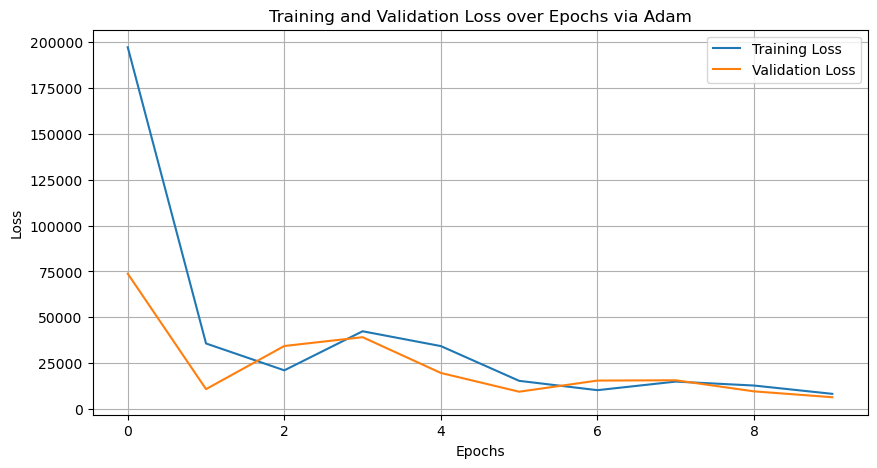

Last epoch train loss: 8349.740478515625
Last epoch validation loss: 6508.878662109375


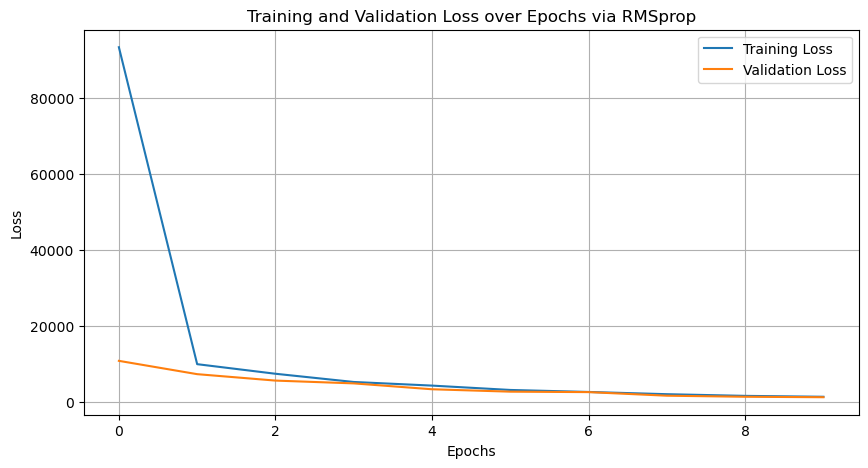

Last epoch train loss: 1276.1846923828125
Last epoch validation loss: 1156.6837768554688
RMSprop 10


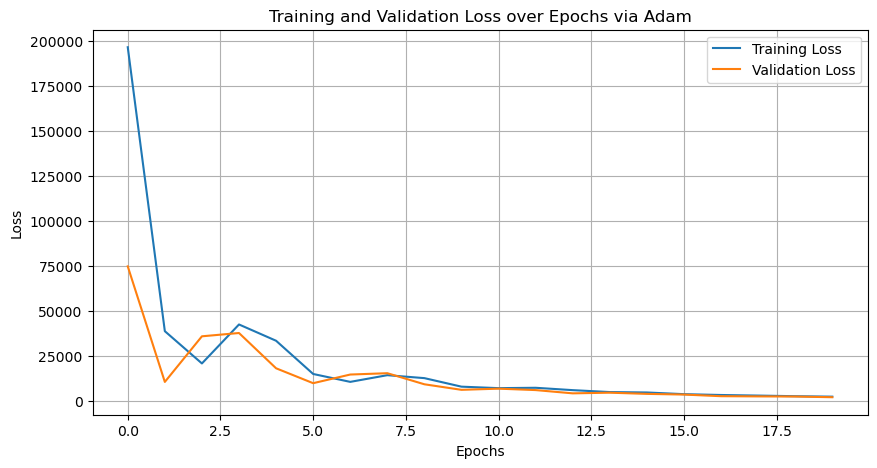

Last epoch train loss: 2324.6714477539062
Last epoch validation loss: 2014.1998901367188


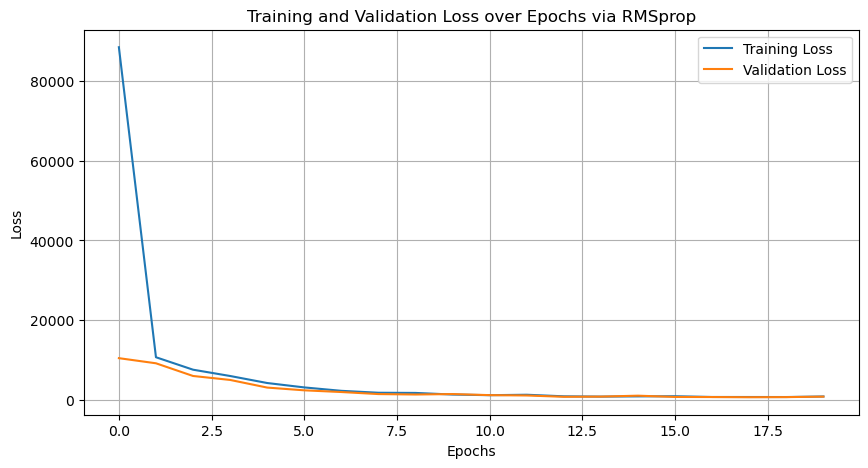

Last epoch train loss: 773.0333862304688
Last epoch validation loss: 732.402099609375
RMSprop 20


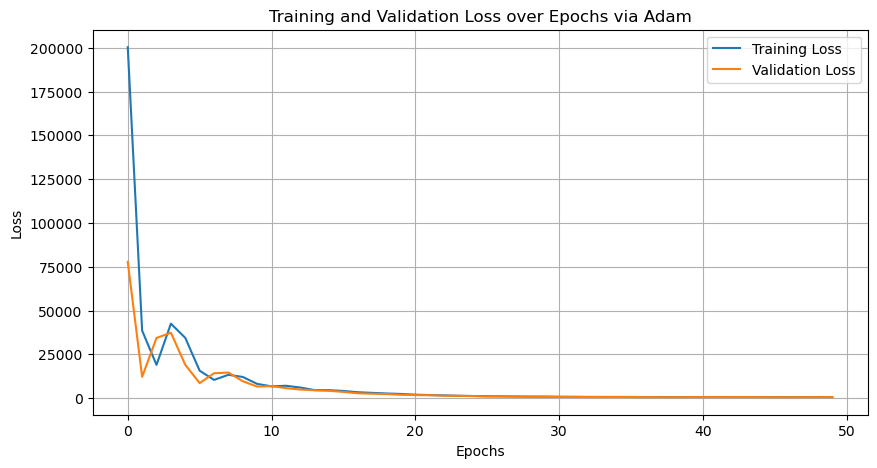

Last epoch train loss: 619.2183074951172
Last epoch validation loss: 668.1122741699219
Adam 50


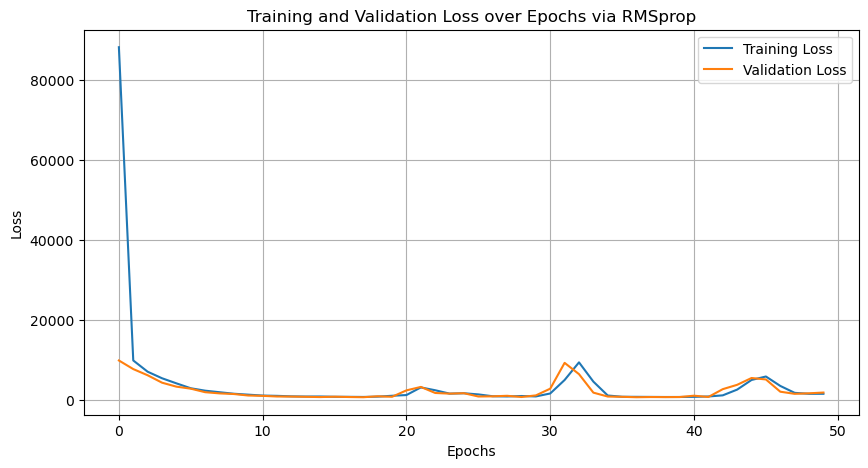

Last epoch train loss: 1431.2737121582031
Last epoch validation loss: 1743.359130859375


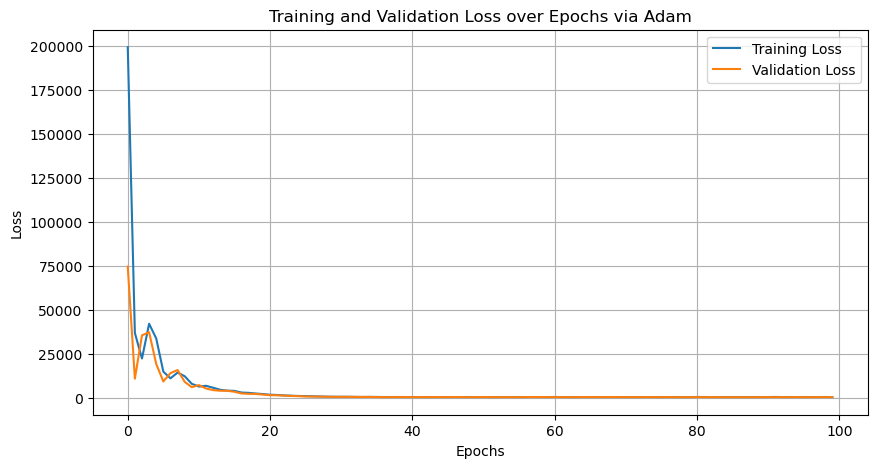

Last epoch train loss: 620.4639892578125
Last epoch validation loss: 605.2563781738281
Adam 100


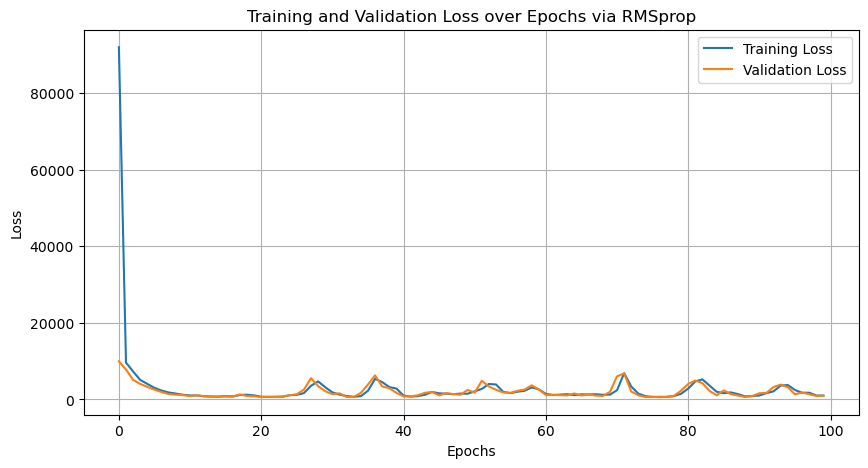

Last epoch train loss: 1003.6787719726562
Last epoch validation loss: 940.6094970703125


In [2293]:
models = []
best_model = None
train_res = []
validation_res = []
for epoch in epochs:
    for name, optimizer_func in optimizers.items():
        model = LinearRegression_torch(in_dim, out_dim)
        optimizer = optimizer_func(model.parameters(), lr=lr)
        metrics = train_cycle(optimizer, model, epoch)
        train_res.append(metrics["train"][-1])
        validation_res.append(metrics["test"][-1])

        plot_metrics(epoch, metrics["train"], metrics["test"], name)
        print(f"Last epoch train loss: {metrics["train"][-1]}\nLast epoch validation loss: {metrics["test"][-1]}")

        if best_model is None:
            best_model = model
        elif train_res[-1] < train_res[-2] and validation_res[-1] < validation_res[-2]:
            best_model = model
            print(name, epoch)
        del(model, optimizer)


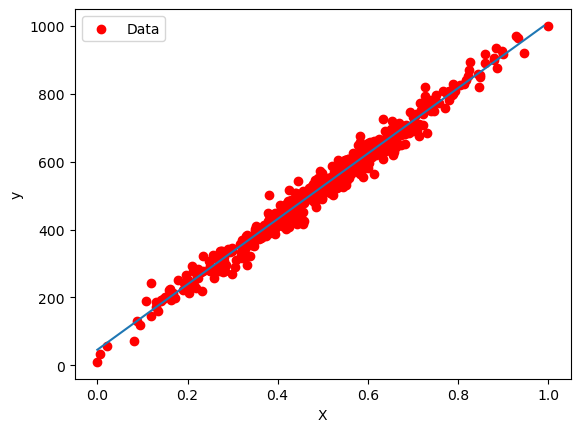

In [2294]:
graph(my_formula, x_range,  X, y, intercept=best_model.linear.bias.item(), coef=best_model.linear.weight.item())

#### I've noticed that learning rate values after 50 don't meaningfully impact performance that is difference is in range (1,2) as for MSE

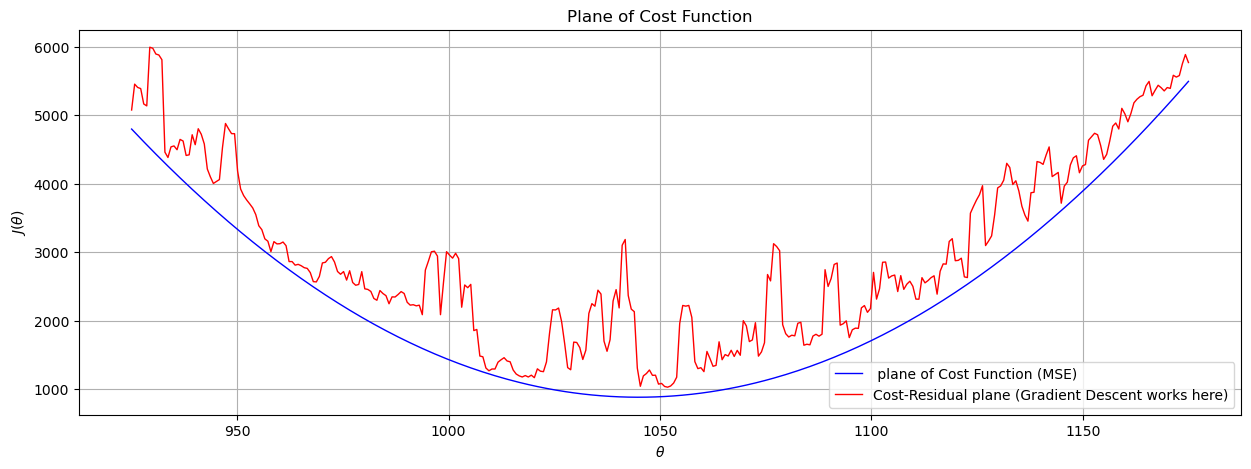

In [2295]:
# Creation of plot of Cost Function

# Cost function for a single parameter theta
def compute_cost(theta_1, x, y_true):
    n = len(y_true)
    y_pred = theta_1 * x
    cost = 1/n * np.sum(np.square(y_true - y_pred))

    return cost

# Moving average
def moving_average(data, window_size):
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode = 'linear_ramp')
    windows = sliding_window_view(padded_data, window_size)
    moving_avg = np.mean(windows, axis = 1)

    if window_size % 2 == 0:
        return moving_avg[:-1]
    else:
        return moving_avg


x_len = x_train_torch.shape[0]

# Generate a range of values for theta_1
theta_vals = np.linspace(925, 1175, x_len)

# Compute the cost for each value of theta
J_vals = np.array([compute_cost(i, x_train_torch.numpy(), y_train_torch.numpy()) for i in theta_vals])

# Compute the residuals for each prediction
y_pred = best_model(x_train_torch.reshape(-1, 1)).detach().numpy()
res_vals = np.square(y_train_torch.numpy().reshape(-1, 1) - y_pred)
# Reshape residuals  into a vector
res_vals  =  res_vals.reshape(len( res_vals))
# Apply moving average to smooth the noise in residuals
smooth_res_vals = moving_average(res_vals, window_size = 5)

# Create plot
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

# Plane of Cost Function
ax.plot(theta_vals, J_vals, label = ' plane of Cost Function (MSE)', color = 'blue', linewidth = 1)
# Plane of Cost Function and Residuals
ax.plot(theta_vals,  smooth_res_vals + J_vals, label = 'Cost-Residual plane (Gradient Descent works here)', color = 'red', linewidth = 1)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$J(\theta)$')
plt.title('Plane of Cost Function')
plt.grid(True, zorder = -1)
plt.legend()
plt.show()